<a href="https://colab.research.google.com/github/arqitect/carcinoma_ml/blob/main/Cancer_Subtype_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Data Loading & Preprocessing
This cell loads the clinical data (containing the cancer labels) and the gene expression data (our features). The code then cleans, merges, and formats the two datasets into a single, model-ready dataframe.

In [2]:
# Load the clinical data, skipping the first 4 comment/metadata lines
clinical_data = pd.read_csv('data_clinical_patient.txt', sep='\t', skiprows=4)
expression_data = pd.read_csv('data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt', sep='\t')

# Select only the columns needed using the correct uppercase names
clinical_subset = clinical_data[['PATIENT_ID', 'SUBTYPE']]

# The expression data has genes as rows and samples as columns, need to flip it.
# Also need to get rid of the 'Entrez_Gene_Id'
expression_transposed = expression_data.drop(columns=['Entrez_Gene_Id']).set_index('Hugo_Symbol').T

# Merge the two dataframes
# The patient IDs in the expression data have extra characters (e.g., TCGA-3C-AAAU-01).
# Ttrim them to match the clinical data's format (TCGA-3C-AAAU).
expression_transposed.index = expression_transposed.index.str.slice(0, 12)
merged_data = pd.merge(clinical_subset, expression_transposed, left_on='PATIENT_ID', right_index=True)

# --- Data Cleaning ---
# Drop rows with missing subtype information
merged_data.dropna(subset=['SUBTYPE'], inplace=True)

# Drop columns that aren't useful for classification
merged_data.drop(columns=['PATIENT_ID'], inplace=True)
# Also drop any rows that have a 'BRCA_Normal' subtype; only want to classify tumors
merged_data = merged_data[merged_data.SUBTYPE != 'BRCA_Normal']


# Display the first 5 rows of final table
print("Final Data Shape:", merged_data.shape)
merged_data.head()

Final Data Shape: (945, 389)


,SUBTYPE,NaN,NaN,UBE2Q2P2,HMGB1P1,NaN,NaN,NaN,RNU12-2P,SSX9P,...,ADRA2B,ADRA2C,ADRB1,ADRB2,ADRB3,ADRBK1,ADRBK2,ADRM1,ADSL,ADSS
0,BRCA_LumA,-1.7608,1.0923,1.0262,-1.7019,-2.5301,NaN,2.6733,-1.9713,-1.0279,...,-1.7962,0.3623,-1.0531,-0.9323,0.1018,2.9456,-1.7113,1.8448,-0.5246,-0.9150
1,BRCA_Her2,-1.7608,0.3525,1.4779,-1.0047,-1.6372,NaN,1.4912,0.6577,-0.5659,...,0.7319,1.2521,0.1045,-0.7549,-0.6357,0.5836,-0.7947,2.2278,-0.6651,0.6132
2,BRCA_LumB,1.1240,0.6434,0.5227,0.9112,0.7974,NaN,1.6861,-1.9713,-1.0279,...,-1.1298,0.6175,-0.3115,-0.2655,0.8647,0.7489,-1.2514,1.6916,-0.8443,-1.9551
3,BRCA_LumA,-1.7608,0.6945,0.7937,0.7417,-0.4534,NaN,1.5887,-0.7346,-1.0279,...,-1.3085,-0.1960,1.4094,0.2801,-0.3479,0.9593,0.3612,0.4034,-0.1343,-0.0038
4,BRCA_LumA,-1.7608,-0.0258,1.1927,-0.5515,-0.7896,NaN,0.5245,-0.7049,-1.0279,...,-0.6236,1.1847,-0.9696,0.3375,-1.3765,-0.3193,-0.6200,-0.2743,0.6033,-0.2324


# Model Training & Evaluation
Now to train the ml model. First separate the data into features (X, the gene expression data) and the target label (y, the cancer subtype). The dataset is then split into a training set for the model to learn from and a testing set to evaluate its performance on unseen data. Then initialize and train a Random Forest Classifier, a powerful algorithm suitable for this task. Finally, make predictions on the test set and print the model's accuracy, which measures the percentage of predictions it got correct.

In [6]:
# Separate features (X) and the target label (y)
X = merged_data.drop('SUBTYPE', axis=1)
y = merged_data['SUBTYPE']

# Convert all column names in X to strings to prevent TypeError
X.columns = X.columns.astype(str)

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Check the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 81.48%


# Interpreting the Results
Beyond just predicting the cancer subtype, we want to understand which biological features are driving the model's decisions. The Random Forest algorithm's feature importance can be calculated, which scores how much each gene contributed to making correct predictions.
This code extracts these scores from the trained model, identifies the top 10 most important genes, and creates a horizontal bar plot to visualize their influence. This analysis connects the model's performance back to the underlying biology.

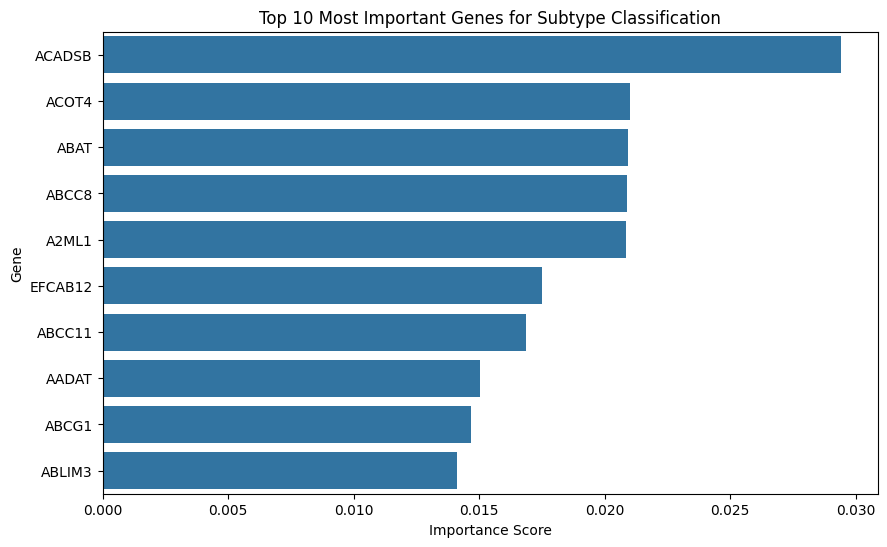

In [7]:
# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)

# Get the top 10 most important genes
top_10_genes = importances.nlargest(10)

# Create a bar plot to visualize them
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_genes.values, y=top_10_genes.index)
plt.title('Top 10 Most Important Genes for Subtype Classification')
plt.xlabel('Importance Score')
plt.ylabel('Gene')
plt.show()

# Confusion Matrix & Classification Report
While overall accuracy is a good measure, it's important to see where the model is succeeding or failing on a class-by-class basis.

First, generate a **confusion matrix**. This is a grid that compares the model's predictions to the true labels. The diagonal from top-left to bottom-right shows the number of correct predictions for each subtype. Any numbers off the diagonal highlight which subtypes the model tends to confuse with one another. Visualize this matrix as a heatmap for easier interpretation.

Second, print a **classification report**. This report provides key metrics for each subtype:

- Precision: Of all the samples the model labeled as a subtype, how many were correct?

- Recall: Of all the true samples of a subtype, how many did the model correctly identify?

- F1-Score: A balanced average of precision and recall.

This detailed analysis gives a much clearer picture of the model's strengths and weaknesses.

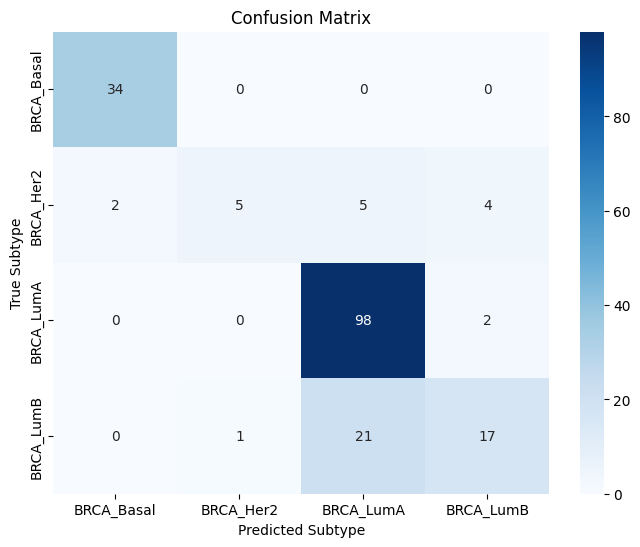


Classification Report:
              precision    recall  f1-score   support

  BRCA_Basal       0.94      1.00      0.97        34
   BRCA_Her2       0.83      0.31      0.45        16
   BRCA_LumA       0.79      0.98      0.88       100
   BRCA_LumB       0.74      0.44      0.55        39

    accuracy                           0.81       189
   macro avg       0.83      0.68      0.71       189
weighted avg       0.81      0.81      0.79       189



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)
subtypes = sorted(y_test.unique()) # Get the class names in order

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=subtypes, yticklabels=subtypes)
plt.xlabel('Predicted Subtype')
plt.ylabel('True Subtype')
plt.title('Confusion Matrix')
plt.show()

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=subtypes))